iteration: 12 obstacle nearby!!
[67.9827560572969, 29.798989873223334, 3.141592653589793]
-1.4951981720785645 1.8310896555269875e-16 0.9663949856699497
-0.2402328626032923 -0.3478521536994043 0.16653585147872668
-0.37808203212653035 -0.807564667064635 0.03479532908664189
-0.5543702514918497 -1.3000663291184156 -0.002665718297510389
-0.7315443083170454 -1.7029651534614743 -0.012717013777516606
-0.9171025308669234 -2.0622105520965226 -0.0182062540086666
-1.113932344086687 -2.3867986501885547 -0.023102770415520585
-1.3223950866461194 -2.6706836312744655 -0.028028798961211923
-1.5409753559545423 -2.904466597302323 -0.033070913096259744
-1.7661041807820497 -3.0784106725994684 -0.038211538960187114
-1.9919103935422373 -3.18369899008519 -0.043397891001188516
-2.210140384948355 -3.2134849157602674 -0.04855130053421598
-2.410391313211192 -3.1639953826501466 -0.053565771158962563
-2.580774578861028 -3.035626680195021 -0.05830512745633548
-2.7090737361045574 -2.833837491423173 -0.0626016917952659

KeyboardInterrupt: 

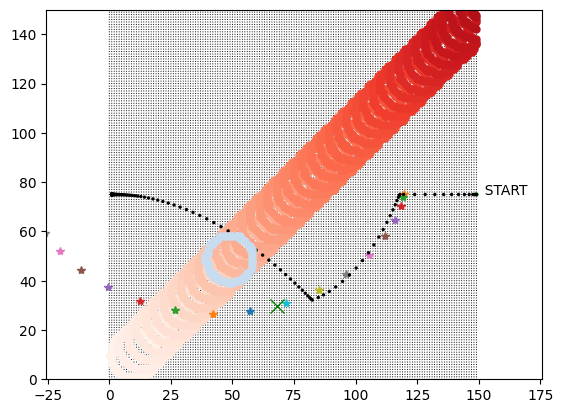

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, acos, sin, nsolve

def drawCoodinate(size, ax):
    x = np.linspace(0,size-1,size)
    y = np.linspace(0,size-1,size)
    u = np.zeros((size,size))
    v = np.zeros((size,size))
    plt.axis('equal')
    ax.quiver(x, y, u, v, scale=1, units='xy')

# Creates axes of plot referenced 'ax'
ax = plt.axes()
size = 150
drawCoodinate(size, ax)
plt.xlim(0, size)
plt.ylim(0, size)

iteration = 0

x_range = 50
y_range = 50

initial_position = [10., 10., np.pi/4]
current_position = initial_position
obstacle_old_position = [0., 0.]
dodge_slope = -(current_position[2])**(-1)
obstacle_velocity = 5.
obstacle_radius = 10.    # (R)
obstacle_x_velo = obstacle_velocity* np.cos(current_position[2])
obstacle_y_velo = obstacle_velocity* np.sin(current_position[2])

robot_radius = 17.    # cm (r)
initial_robot_position = [149., 75., np.pi]    # [x, y, theta]
current_robot_position = initial_robot_position
robot_velocity = 10.
robot_omega = 0.
original_robot_velo = robot_velocity
original_robot_omega = robot_omega
robot_x_velo = robot_velocity* np.cos(current_robot_position[2])
robot_y_velo = robot_velocity* np.sin(current_robot_position[2])

temp_target = [0., 0., 0.]
cycloid_target = []
target = [1., 75., np.pi]
diff_arr = [0., 0., 0.]
cycloid_diff_arr = [[[0.] * 3]]  # the difference of the current position with points in cycloid
controller_index = 0

sampling_freq = 1.    # Hz
safety_margin = 3*robot_radius

turn = 0
nearby = 0

def solve_cycloid(x, y):
    # Define symbolic variable
    c = symbols('c')

    # Define the equation
    equation = Eq(x - c * acos(1 - y / c) + c * sin(acos(1 - y / c)), 0)

    # Solve the equation numerically
    initial_guesses = np.arange(-100., 100.1, 1)  # Generate initial guesses from -100 to 100 with a step of 0.1

    for guess in initial_guesses:
        try:
            r = nsolve(equation, c, guess)
            return round(r, 4)
        except ValueError:
            continue

    # If no solution is found, return None or raise an exception
    raise ValueError("Unable to find a solution. Try different initial guesses.")

def cycloid_equation(x_, y_, num_points=100):
    r = solve_cycloid(x_, y_)
    t_values = np.linspace(0, 2 * np.pi, num_points)
    x = r * (t_values - np.sin(t_values))
    y = r * (1 - np.cos(t_values))

    return x, y

def crossing(x, y, iteration, colorcode, zorder_index):
    if colorcode == 1:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Reds((iteration+1)/50), zorder=zorder_index)
    elif colorcode == 2:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Greens((iteration+1)/50), zorder=zorder_index)
    elif colorcode == 3:
        plt.plot(x, y, marker='o', markersize=5, color=plt.cm.Blues((iteration+1)/50), zorder=zorder_index)

def brachistochrone_drawer():
    pass

def controller(diff_x, diff_y, diff_theta, controller_index):
    global robot_velocity, robot_omega, current_robot_position, robot_x_velo, robot_y_velo
    k1 = (1100e-4)      # speed
    k2 = (5*k1)      # trajectory

    z1 = diff_theta
    z2 = diff_x*np.cos(diff_theta) + diff_y*np.sin(diff_theta)
    z3 = diff_x*np.sin(diff_theta) - diff_y*np.cos(diff_theta)
    
    x1 = z1
    x2 = z2
    x3 = -2*z3+z1*z2

    denominator = x1**2+x2**2
    u1 = -k1*x1 + ((k2*x3)/denominator)*x2
    u2 = -k1*x2 - ((k2*x3)/denominator)*x1
    
    robot_omega = u1
    # robot_velocity = 1*(u2 + z3*u1)   # the linear velocoty of the robot
    # get start from zero velocity
    slow_region = 30
    if controller_index <= slow_region:
        robot_velocity = ((controller_index+1)/(slow_region*1.1))*(u2 + z3*u1)
    else:
        robot_velocity = 1*(u2 + z3*u1)   # the linear velocoty of the robot
    robot_x_velo = -robot_velocity* np.cos(current_robot_position[2])      # the negative sign should be modified
    robot_y_velo = -robot_velocity* np.sin(current_robot_position[2])      # the negative sign should be modified


# plotting trajectory
while (0<current_position[0] and current_position[0]<size and 0<current_position[1] and current_position[1]<size 
       or 0<current_robot_position[0] and current_robot_position[0]<size and 0<current_robot_position[1] and current_robot_position[1]<size):
    # plot the starting point
    if iteration == 0:
        plt.quiver(current_robot_position[0], current_robot_position[1], 
                   np.cos(current_robot_position[2]), np.sin(current_robot_position[2]),
                     scale=1, units='xy')
        plt.plot(current_robot_position[0], current_robot_position[1], marker="o", markersize=2, markeredgecolor="green", markerfacecolor="green")
        plt.text(current_robot_position[0], current_robot_position[1], '  START', zorder = 3)

    # check if robot near the obstacle
    if np.sqrt((current_position[0]-current_robot_position[0])**2+
               (current_position[1]-current_robot_position[1])**2
               ) <= obstacle_radius+robot_radius+safety_margin and turn == 0:
        print("iteration:", iteration+1, "obstacle nearby!!")
        nearby = 1
        # get the trajectory of obstacle through robot, the formula of the trajectory: y=ax+b
        a = np.tan(current_position[2])
        b = current_position[1] - np.tan(current_position[2])*current_position[0]

        # determine the temporary distination robot should go
        if (a*current_robot_position[0]-current_robot_position[1]+b > 0): # if the robot right to trajectory, ### Robot go RIGHT ###
            temp_target[0] = current_position[0] + (obstacle_radius+robot_radius)*np.cos(np.pi/2-current_position[2])
            temp_target[1] = current_position[1] - (obstacle_radius+robot_radius)*np.sin(np.pi/2-current_position[2])
        else:                                                             # if the robot left to trajectory, ### Robot go LEFT ###
            temp_target[0] = current_position[0] - (obstacle_radius+robot_radius)*np.cos(np.pi/2-current_position[2])
            temp_target[1] = current_position[1] + (obstacle_radius+robot_radius)*np.sin(np.pi/2-current_position[2])
        temp_target[2] = current_robot_position[2]
        plt.plot(temp_target[0], temp_target[1], marker='x', markersize=10, color = 'g')
        print(temp_target)
        # get the relative position to the current position of the temp. target
        x_ = temp_target[0] - current_robot_position[0]
        y_ = temp_target[1] - current_robot_position[1]
        # get the cycloid
        x, y = cycloid_equation(x_, y_)
        # move back To original position
        for k in range(len(x)):
            if k % 5 == 0:
                plt.plot(x[k]+current_robot_position[0], y[k]+current_robot_position[1], marker='*', zorder=1)
                cycloid_target.append([x[k]+current_robot_position[0], y[k]+current_robot_position[1], current_robot_position[2]])
        controller_index = 0
        turn = 1      
    else:
        # controller to distination
        for j in range(3):
            diff_arr[j] = current_robot_position[j] - target[j]  # original one
            # diff_arr[i][j] = current_robot_position[j] - cycloid_target[i][j]
            
        controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index)  
        controller_index += 1  

    # calculate the difference
    # dodging process
    if turn == 1:
        for j in range(3):
            diff_arr[j] = current_robot_position[j] - temp_target[j]

        # for i in range(len())

        controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index) 
        controller_index += 1  
        print(robot_x_velo, robot_y_velo, robot_omega)   # print for debugging
        if np.sqrt((current_robot_position[0]-temp_target[0])**2 + 
                   (current_robot_position[1]-temp_target[1])**2) < 1.2*robot_radius:  # if robot is close enough to temp. distination, continue
            turn = 0
            controller_index = 0

    # plot the current status (arrow)
    plt.quiver(current_robot_position[0], current_robot_position[1],
                1*np.cos(current_robot_position[2]), 1*np.sin(current_robot_position[2]),
                scale=0.8, units='xy', zorder = 3)

    # plot the area for obstacle and robot
    for x in range(size):
        for y in range(size):
            if (np.sqrt((current_position[0]-x)**2 + (current_position[1]-y)**2) <= obstacle_radius
                and np.sqrt((current_position[0]-x)**2 + (current_position[1]-y)**2) >= obstacle_radius - 1) and not nearby:
                crossing(x, y, iteration, 1, 1)
            elif (np.sqrt((current_position[0]-x)**2 + (current_position[1]-y)**2) <= obstacle_radius
                and np.sqrt((current_position[0]-x)**2 + (current_position[1]-y)**2) >= obstacle_radius - 1) and nearby:
                crossing(x, y, iteration, 3, 4)

    
            # if (np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) <= robot_radius
            #     and np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) >= robot_radius - 1) and not nearby:
            #     crossing(x, y, iteration, 2, 2)
            # elif (np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) <= robot_radius
            #     and np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) >= robot_radius - 1) and nearby:
            #     crossing(x, y, iteration, 3, 4)

    nearby = 0
    
    # moving to next position
    current_position[0] += obstacle_x_velo*(1/sampling_freq)
    current_position[1] += obstacle_y_velo*(1/sampling_freq)
    current_robot_position[0] += robot_x_velo*(1/sampling_freq)
    current_robot_position[1] += robot_y_velo*(1/sampling_freq)
    current_robot_position[2] += robot_omega*(1/sampling_freq)
    iteration += 1


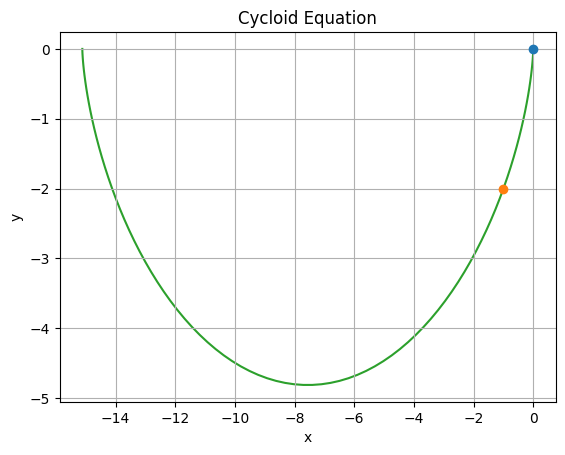

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, acos, sin, nsolve

def solve_cycloid(x, y):
    # Define symbolic variable
    c = symbols('c')

    # Define the equation
    equation = Eq(x - c * acos(1 - y / c) + c * sin(acos(1 - y / c)), 0)

    # Solve the equation numerically
    initial_guesses = np.arange(-10., 10.1, 0.1)  # Generate initial guesses from -10 to 10 with a step of 0.1

    for guess in initial_guesses:
        try:
            r = nsolve(equation, c, guess)
            return round(r, 4)
        except ValueError:
            continue

    # If no solution is found, return None or raise an exception
    raise ValueError("Unable to find a solution. Try different initial guesses.")

def cycloid_equation(x_, y_, num_points=100):
    r = solve_cycloid(x_, y_)
    t_values = np.linspace(0, 2 * np.pi, num_points)
    x = r * (t_values - np.sin(t_values))
    y = r * (1 - np.cos(t_values))

    return x, y

# define a point to pass
x_, y_ = -1, -2

# get the cycloid
x, y = cycloid_equation(x_, y_)

plt.plot(0., 0., x_, y_, marker='o', zorder=2)
plt.plot(x, y, zorder=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cycloid Equation')
plt.grid(True)
plt.show()


In [210]:
from sympy import symbols, Eq, acos, sin, nsolve
import numpy as np

def solve_cycloid(x, y):
    # Define symbolic variable
    c = symbols('c')

    # Define the equation
    equation = Eq(x - c * acos(1 - y / c) + c * sin(acos(1 - y / c)), 0)

    # Solve the equation numerically
    initial_guesses = np.arange(0.1, 10.1, 0.1)  # Generate initial guesses from 0.1 to 10 with a step of 0.1

    for guess in initial_guesses:
        try:
            solution = nsolve(equation, c, guess)
            return solution
        except ValueError:
            continue

    # If no solution is found, return None or raise an exception
    raise ValueError("Unable to find a solution. Try different initial guesses.")

x = 3.0
y = 3.0
result = round(solve_cycloid(x, y), 4)
print(result)


1.7188
